In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

In [6]:
def get_data(batch_size: int):
    train_transform = v2.Compose([
        # v2.RandomCrop(32, padding = 4),
        # v2.RandomHorizontalFlip(),
        # v2.RandomRotation(5),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2470, 0.2435, 0.2616),
        ),
        v2.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
    ])
    test_transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2470, 0.2435, 0.2616),
        ),
    ])
    train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=train_transform, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=test_transform, download=True)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    return train_loader, test_loader 

def train_step(model, criterion, optimizer, batch):
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)


    preds = model(images)
    loss = criterion(preds, labels)

    correct = (preds.argmax(dim=1) == labels).sum().item()
    total = labels.size(0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), correct, total


def train(model, criterion, optimizer, scheduler, train_loader, num_epochs: int, plot_live=True):
    model.train()  # Ensure model is in training mode
    import time
    
    losses = []
    steps = []
    step_count = 0
    
    train_start_time = time.time()
    for epoch in range(num_epochs):
        start_time = time.time()
        correct = 0
        total = 0
        for step, batch in enumerate(train_loader, start=1):
            loss, _correct, _total = train_step(model, criterion, optimizer, batch)
            step_count += 1
            losses.append(loss)
            steps.append(step_count)
            correct += _correct
            total += _total
        scheduler.step()
        duration = time.time() - start_time
        accuracy = 100 * correct / total
        if epoch % 2 == 0 or num_epochs == epoch - 1:
            print(f"Epoch {epoch} loss: {losses[-1]:.4f}, duration: {duration:.2f}s, accuracy: {accuracy:.2f}%")

    train_duration = time.time() - train_start_time
    print(f"Training duration: {train_duration:.2f}s")
    return losses, steps
            

@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy of the network on the 10000 test images: {accuracy:.2f} %")
    return accuracy

def check_model_outputs(model, train_loader, criterion):
    """Check initial model outputs to diagnose low loss issue"""
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(train_loader))
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        preds = model(images)
        loss = criterion(preds, labels)
        
        # Get probabilities
        probs = torch.softmax(preds, dim=1)
        max_probs, predicted = torch.max(probs, dim=1)
        
        print(f"Initial loss: {loss.item():.4f}")
        print(f"Average max probability: {max_probs.mean().item():.4f}")
        print(f"Predicted classes (first 10): {predicted[:10].cpu().tolist()}")
        print(f"True classes (first 10): {labels[:10].cpu().tolist()}")
        print(f"Logits range: [{preds.min().item():.2f}, {preds.max().item():.2f}]")
        print(f"Logits mean: {preds.mean().item():.2f}, std: {preds.std().item():.2f}")
        
    model.train()

def plot_loss(losses, steps, window_size=100):
    """Plot training loss with optional moving average"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(12, 6))
    
    # Plot raw losses (can be noisy)
    plt.subplot(1, 2, 1)
    plt.plot(steps, losses, alpha=0.3, color='blue', label='Raw loss')
    
    # Calculate moving average if we have enough points
    if len(losses) >= window_size:
        moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        moving_avg_steps = steps[window_size-1:]
        plt.plot(moving_avg_steps, moving_avg, color='red', linewidth=2, label=f'Moving avg ({window_size} steps)')
    
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss (All Steps)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot smoothed version (every 100 steps for cleaner view)
    plt.subplot(1, 2, 2)
    if len(losses) >= 100:
        # Sample every 100th step for cleaner visualization
        sampled_steps = steps[::100]
        sampled_losses = losses[::100]
        plt.plot(sampled_steps, sampled_losses, marker='o', markersize=4, linewidth=2, color='green', label='Loss (every 100 steps)')
    else:
        plt.plot(steps, losses, marker='o', markersize=4, linewidth=2, color='green', label='Loss')
    
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss (Sampled)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nLoss Statistics:")
    print(f"  Initial loss: {losses[0]:.4f}")
    print(f"  Final loss: {losses[-1]:.4f}")
    print(f"  Min loss: {min(losses):.4f}")
    print(f"  Max loss: {max(losses):.4f}")
    print(f"  Average loss: {np.mean(losses):.4f}")



In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        return out
        
        

class ResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        init_conv_channels = 32
        
        self.layer1 = nn.Sequential(
            ResidualBlock(in_channels=3, out_channels=init_conv_channels, stride=1),
            ResidualBlock(in_channels=init_conv_channels, out_channels=init_conv_channels, stride=1),
            ResidualBlock(in_channels=init_conv_channels, out_channels=init_conv_channels, stride=1)
        )

        self.layer2 = nn.Sequential(
            ResidualBlock(in_channels=init_conv_channels, out_channels=init_conv_channels * 2, stride=2),
            ResidualBlock(in_channels=init_conv_channels * 2, out_channels=init_conv_channels * 2, stride=1),
            ResidualBlock(in_channels=init_conv_channels * 2, out_channels=init_conv_channels * 2, stride=1)
        )
        # B, 3, 32, 32 -> B, 64, 16, 16
        
        self.layer3 = nn.Sequential(
            ResidualBlock(in_channels=init_conv_channels * 2, out_channels=init_conv_channels * 4, stride=2),
            ResidualBlock(in_channels=init_conv_channels * 4, out_channels=init_conv_channels * 4, stride=1),
            ResidualBlock(in_channels=init_conv_channels * 4, out_channels=init_conv_channels * 4, stride=1)
        )
        
        # B, 64, 16, 16 -> B, 128, 8, 8  

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(init_conv_channels * 4, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.gap(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [8]:
model = ResNet(10)
model = model.to(DEVICE)
num_epochs = 4

# Reset BatchNorm running statistics to ensure fresh start
# This is important if the model was previously trained or if you're re-running cells
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.reset_running_stats()

model.train()  # Ensure model is in training mode
train_loader, test_loader = get_data(100)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,  momentum=0.9, weight_decay=4e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)


size = 0
for param in model.parameters():
    size += param.numel()
print(f"Model size: {size/1e6:.2f}M")

# Diagnostic: Check initial model outputs before training
# Expected: Loss should be around 2.3 (which is -log(1/10) for random 10-class prediction)
# If loss is much lower, BatchNorm running stats might be from a previous run
print("=== Checking initial model state ===")
check_model_outputs(model, train_loader, criterion)
print("\nExpected initial loss: ~2.3 (random guessing)")
print("If loss is much lower, the model may have been trained before or BatchNorm stats are stale.\n")


Model size: 1.08M
=== Checking initial model state ===


/Users/ramana/Documents/personal/pytorch-examples/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Initial loss: 2.3081
Average max probability: 0.1122
Predicted classes (first 10): [0, 5, 5, 0, 0, 0, 5, 0, 0, 0]
True classes (first 10): [2, 5, 9, 8, 8, 4, 0, 4, 4, 5]
Logits range: [-0.15, 0.23]
Logits mean: 0.01, std: 0.07

Expected initial loss: ~2.3 (random guessing)
If loss is much lower, the model may have been trained before or BatchNorm stats are stale.



Epoch 0 loss: 1.4486, duration: 24.79s, accuracy: 42.38%
Epoch 2 loss: 0.9550, duration: 22.62s, accuracy: 72.88%
Training duration: 93.77s


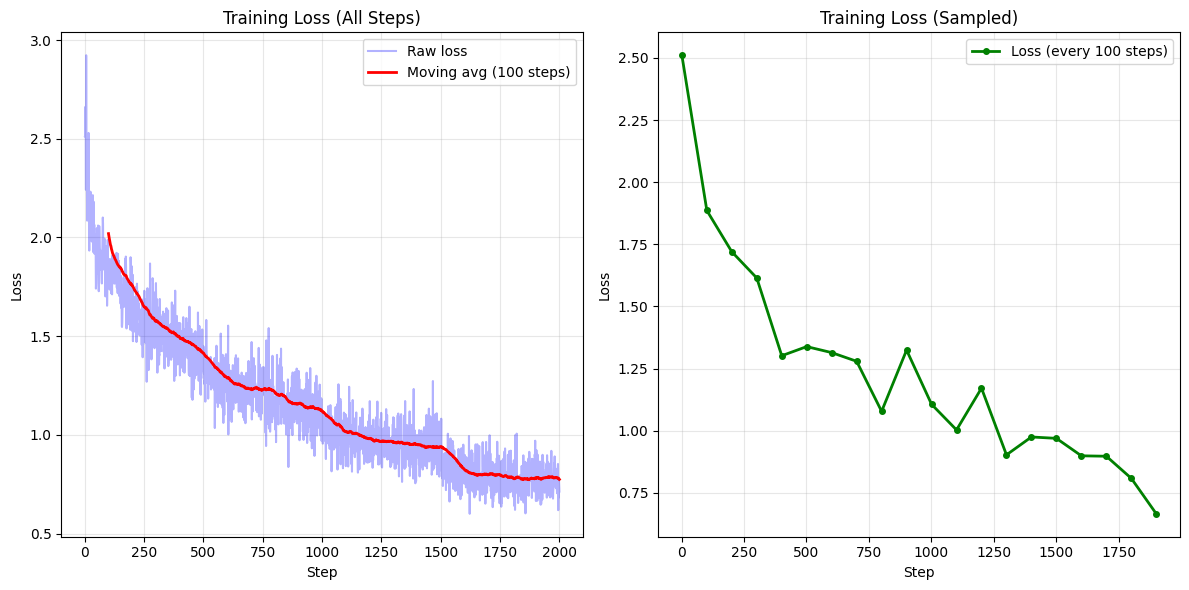


Loss Statistics:
  Initial loss: 2.5110
  Final loss: 0.7131
  Min loss: 0.6004
  Max loss: 2.9230
  Average loss: 1.1549


In [9]:
# Train the model with live loss plotting
# The plot will update in real-time as training progresses
losses, steps = train(model, criterion, optimizer, scheduler, train_loader, num_epochs)

# Optional: Create a final static plot if needed
plot_loss(losses, steps)

In [10]:
evaluate(model, test_loader)

# print optimizer current lr
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

losses[0:10]

/Users/ramana/Documents/personal/pytorch-examples/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy of the network on the 10000 test images: 80.46 %
Current learning rate: 0.0001


[2.5109713077545166,
 2.5125746726989746,
 2.662299156188965,
 2.592149257659912,
 2.241597890853882,
 2.923031806945801,
 2.3446097373962402,
 2.4533331394195557,
 2.3065121173858643,
 2.0853054523468018]